<a href="https://colab.research.google.com/github/Jeremy26/visual_fusion_course/blob/main/Project_a_3D_Point_to_a_2D_Image_Starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LiDAR Camera Projection Notebook

We are going to do the following:
1. **Load a Point Cloud** and **Visualize it**
2. **Load an Image** and **Visualize it**
3. **Fuse LiDAR and Camera manually** (i.e. without coding it)
4. **Project LiDAR Point Clouds to an Image**
5. **Run the algorithms on a video**

Ready? Let's get started!

## Load the Data and Visualize it!

### Link Google Colab to Google Drive

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

os.chdir("/content/drive/My Drive/sensor_fusion")
!ls

### Import the necessary libraries

In [ ]:
!pip install open3d==0.12.0 # Version 12

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import open3d as o3d

### Load the Files

In [ ]:
image_files = sorted(glob.glob("data/img/*.png"))
point_files = sorted(glob.glob("data/velodyne/*.pcd"))
label_files = sorted(glob.glob("data/label/*.txt"))
calib_files = sorted(glob.glob("data/calib/*.txt"))

index = 0
pcd_file = point_files[index]
image = cv2.cvtColor(cv2.imread(image_files[index]), cv2.COLOR_BGR2RGB)
cloud = o3d.io.read_point_cloud(pcd_file)
points= np.asarray(cloud.points)

### Optional - If your LiDAR file is in binary extension '.bin', use this piece of code to turn it into a '.pcd' and save it

In [ ]:
## BIN TO PCD
import numpy as np
import struct
size_float = 4
list_pcd = []

file_to_open = point_files[index]
file_to_save = str(point_files[index])[:-3]+"pcd"
with open (file_to_open, "rb") as f:
    byte = f.read(size_float*4)
    while byte:
        x,y,z,intensity = struct.unpack("ffff", byte)
        list_pcd.append([x, y, z])
        byte = f.read(size_float*4)
np_pcd = np.asarray(list_pcd)
pcd = o3d.geometry.PointCloud()
v3d = o3d.utility.Vector3dVector
pcd.points = v3d(np_pcd)

o3d.io.write_point_cloud(file_to_save, pcd)


### Visualize the Image

In [ ]:
f, (ax1) = plt.subplots(1, 1, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Image', fontsize=30)

### Visualize the Point Clouds

To visualize point clouds inside Google Colab, I highly recommend pypotree. It's a notebook version of Potree Point Cloud Viewer, and helps visualize smaller point clouds easily! 

In [ ]:
!pip install pypotree #https://github.com/centreborelli/pypotree

In [ ]:
import pypotree 
cloudpath = pypotree.generate_cloud_for_display(points)
pypotree.display_cloud_colab(cloudpath)

##Project the Points in the Image <p>
That part was possibly the hardest to understand. We want to project the 3D points onto the image.<p>

It means we'll need to: <p>

*   Select the Point that are **visible** in the image 
*   Convert the Points **from the LiDAR frame to the Camera Frame** 
*   Find a way to project **from the Camera Frame to the Image Frame** 😭




### 1 - Read the Calibration File

The first step is to read the calibration files. For each image, we have an associated calibration file that states:<p>


*   The instrinsic and extrinsic camera calibration parameters
*   The velodyne to camera matrices
*   All the other "sensor A" to "sensor B" matrices
<p>
They are made from this setup:<p>

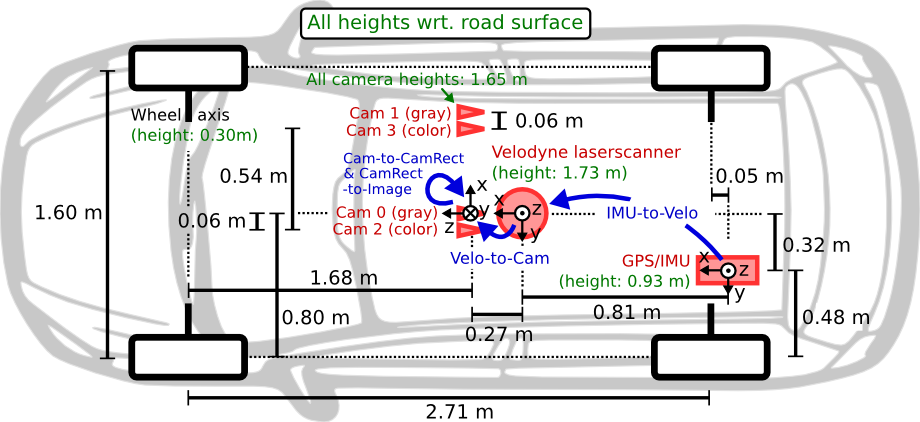
<p>
Not everything matters to us here, only a few things:
*    **Velo-To-Cam is a variable we'll call V2C** -- It gives the rotation and translation matrices from the Velodyne to the Left Grayscale camera.
*    **R0_rect is used in Stereo Vision** to make the images co-planar. It's our case here.
*   **P2 is the matrix obtained after camera calibration**. It contains the intrinsic matrix K and the extrinsic.


In [ ]:
### TODO: Code the LiDAR2Camera Init function

class LiDAR2Camera(object):
    def __init__(self, calib_file):
        calibs = self.read_calib_file(calib_file)
        self.P = 
        # Rigid transform from Velodyne coord to reference camera coord
        self.V2C = 
        # Rotation from reference camera coord to rect camera coord
        self.R0 =

    def read_calib_file(self, filepath):
        """ Read in a calibration file and parse into a dictionary.
        Ref: https://github.com/utiasSTARS/pykitti/blob/master/pykitti/utils.py
        """
        data = {}
        with open(filepath, "r") as f:
            for line in f.readlines():
                line = line.rstrip()
                if len(line) == 0:
                    continue
                key, value = line.split(":", 1)
                # The only non-float values in these files are dates, which
                # we don't care about anyway
                try:
                    data[key] = np.array([float(x) for x in value.split()])
                except ValueError:
                    pass
        return data

In [ ]:
lidar2cam = LiDAR2Camera(calib_files[index])
print("P :"+str(lidar2cam.P))
print("-")
print("RO "+str(lidar2cam.R0))
print("-")
print("Velo 2 Cam " +str(lidar2cam.V2C))
print("-")
#print("Cam 2 Velo" + str(lidar2cam.C2V))

### 2 - Apply the  Formula

The main formula we'll use will be as follows:<p>
**Y(2D) = P x R0 x R|t x X (3D)** 

However, when looking at the dimensions:

*   P: [3x4]
*   R0: [3x3]
*   R|t = Velo2Cam: [3x4]
*   X: [3x1]

We'll need to convert some points into Homogeneous Coordinates:
* RO must go from 3x3 to 4x3
* x must go from 3x1 to 4x1

Then, to retrieve the cartesian system, we'll divide the [3x1] Vector by the value in the last row.

In [ ]:
## HELPER - DO NOT USE FOR NOW
def cart2hom(self, pts_3d):
    """ Input: nx3 points in Cartesian
        Oupput: nx4 points in Homogeneous by pending 1
    """
    n = pts_3d.shape[0]
    pts_3d_hom = np.hstack((pts_3d, np.ones((n, 1))))
    return pts_3d_hom

LiDAR2Camera.cart2hom = cart2hom

In [ ]:

def project_velo_to_image(self, pts_3d_velo):
    '''
    Input: 3D points in Velodyne Frame [nx3]
    Output: 2D Pixels in Image Frame [nx2]
    '''
    pass

LiDAR2Camera.project_velo_to_image = project_velo_to_image
print(points[:5,:3])
print("Euclidean Pixels "+str(lidar2cam.project_velo_to_image(points[:5,:3])))


### 1.3 - Get the Points in the Field Of View Only

In [ ]:
def get_lidar_in_image_fov(self,pc_velo, xmin, ymin, xmax, ymax, return_more=False, clip_distance=2.0):
    """ Filter lidar points, keep those in image FOV """
    pts_2d = self.project_velo_to_image(pc_velo)
    fov_inds = # TODO: Fill in the blank

    fov_inds = # TODO: Remove points that are closer than the clip distance
    imgfov_pc_velo = pc_velo[fov_inds, :]
    if return_more:
        return imgfov_pc_velo, pts_2d, fov_inds
    else:
        return imgfov_pc_velo
    
LiDAR2Camera.get_lidar_in_image_fov = get_lidar_in_image_fov

###1.4 -- Draw the Points in the Image

In [ ]:
def show_lidar_on_image(self, pc_velo, img, debug="False"):
    """ Project LiDAR points to image """
    imgfov_pc_velo, pts_2d, fov_inds = self.get_lidar_in_image_fov(
        pc_velo, 0, 0, img.shape[1], img.shape[0], True
    )

    self.imgfov_pts_2d = pts_2d[fov_inds, :]

    cmap = plt.cm.get_cmap("hsv", 256)
    cmap = np.array([cmap(i) for i in range(256)])[:, :3] * 255
    
    self.imgfov_pc_velo = imgfov_pc_velo
    
    for i in range(self.imgfov_pts_2d.shape[0]):
        pass
        # TODO: Draw a circle at the pixel position and depending on its color
        
    return img

LiDAR2Camera.show_lidar_on_image = show_lidar_on_image

In [ ]:
#img_3 = lidar2cam.show_lidar_on_image(points[:,:3], image)
img_3 = image.copy()
img_3 = lidar2cam.show_lidar_on_image(points[:,:3], img_3)
plt.figure(figsize=(14,7))
plt.imshow(img_3)
plt.show()

## Recording a  Video

In [ ]:
video_images = sorted(glob.glob("data/video/images/*.png"))
video_points = sorted(glob.glob("data/video/points/*.pcd"))

# Build a LiDAR2Cam object
lidar2cam_video = LiDAR2Camera(calib_files[0])

result_video = []

for idx, img in enumerate(video_images):
    image = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    point_cloud = np.asarray(o3d.io.read_point_cloud(video_points[idx]).points)
    result_video.append(lidar2cam_video.show_lidar_on_image(point_cloud, image))

out = cv2.VideoWriter('output/out.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (image.shape[1],image.shape[0]))
 
for i in range(len(result_video)):
    out.write(cv2.cvtColor(result_video[i], cv2.COLOR_BGR2RGB))
    #out.write(result_video[i])
out.release()